# Day 18: Random Vectors, Continued

---

- cleanup
- multivariate gaussian
  - fully defined by its mean and covariance
  - isotonic gaussian
  - basic calculations: sums of gaussians
- limitations of the multivariate gaussian
  - Infinite support
  - Symmetry
  - Unimodal


In [2]:
import pandas as pd 
import grama as gr 
import numpy as np

from scipy.stats import lognorm
from plotnine import *

DF = gr.Intention()


## Cleanup

---

Here are some more basic facts we didn't get to last time:


In [1]:
from grama.models import make_prlc_rand
md_prlc = make_prlc_rand()


## Independence

Two variables $X, Y$ are *independent* if their joint CDF factors:

$$F(x, y) = F_X(x) F_Y(y)$$

> When you call `gr.cp_copula_independence()`, you are assuming that all variables are mutually independent.

For instance, the `prlc` model assumes the component values vary independently, which we can see under `copula:`


In [3]:
md_prlc


model: RLC with component tolerances

  inputs:
    var_det:
      R: [0.001, 1.0]
      L: [1e-09, 0.001]
      C: [0.001, 100]

    var_rand:
      dR: (+0) uniform, {'loc': -0.05, 'scale': 0.1}
      dL: (+0) uniform, {'loc': -0.1, 'scale': 0.2}
      dC: (+0) uniform, {'loc': -0.2, 'scale': 1.0}

    copula:
      Independence copula

  functions:
      f0: ['R', 'dR', 'L', 'dL', 'C', 'dC'] -> ['Rr', 'Lr', 'Cr']
      f1: ['Lr', 'Cr'] -> ['omega0']
      parallel RLC: ['omega0', 'Rr', 'Cr'] -> ['Q']

## Covariance

$$\text{Var}[X] = \mathbb{E}[(X - \mu_X)(X - \mu_X)]$$

$$\text{Cov}[X, Y] = \mathbb{E}[(X - \mu_X)(Y - \mu_Y)]$$

Variance is a measure of variation in a single variable $X$.

Covariance is a measure of co-variation between two variables $X, Y$.


## Correlation

A dimensionless measure of dependence

$$\rho_{X, Y} = \frac{\text{Cov}[X,Y]}{\sigma_X \sigma_Y}$$


## Important caveat: Correlation is **not** a slope!

![](https://upload.wikimedia.org/wikipedia/commons/d/d4/Correlation_examples2.svg)

This is a super-important figure. The value above each panel gives the correlation $\rho_{X,Y}$ for that set of data. Note that correlation is not a slope! Rather, it is a measure of how close to linear a trend is. The less variable that trend, the close to $\pm1$ is $\rho$. Also, nonlinear trends can be entirely missed by $\rho$.


## Important caveat!

A lack of correlation does **not** mean a lack of dependence. The following data have exactly zero correlation, but clearly there's some dependence between the variables:


            rho
0  6.245005e-17


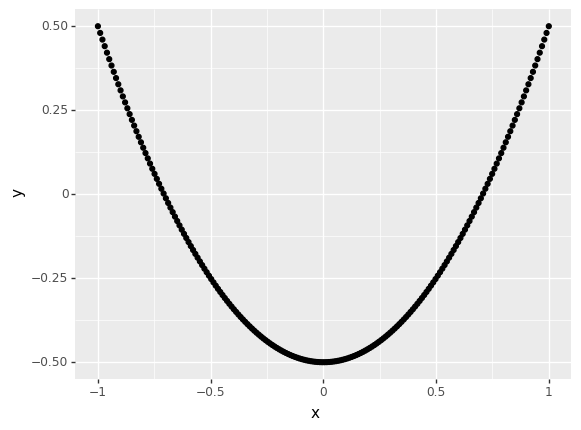

<ggplot: (8765621832261)>

In [9]:
df_quad = (
    gr.df_make(x=np.linspace(-1, +1, num=200))
    >> gr.tf_mutate(y=DF.x**2 - 0.5)
)

print(
    df_quad
    >> gr.tf_summarize(rho=gr.corr(DF.x, DF.y))
)

(
    df_quad
    >> ggplot(aes("x", "y"))
    + geom_point()
)

However, independence *does* imply zero covariance:

$$\text{Cov}[X, Y] = \int\int (x - \mu_X)(y - \mu_Y) f_{X,Y}(x, y) dx dy = \int\int (x - \mu_X)(y - \mu_Y) f_X(x) f_Y(y) dx dy = \mathbb{E}[X - \mu_X] \mathbb{E}[Y - \mu_Y] = 0$$

and hence zero correlation.


## Multivariate Gaussian

---

Here's a "golden rule" that we'll unpack:

> "A multivariate gaussian is fully defined by its mean and variance"

Let's start from an example of an multivariate gaussian, and point out the general properties from this specific example:


In [9]:
md_mv = (
    gr.Model("Multivariate Gaussian")
    >> gr.cp_marginals(
        x=dict(dist="norm", loc=0, scale=1),
        y=dict(dist="norm", loc=0, scale=1),
        z=dict(dist="norm", loc=0, scale=1),
    )
    >> gr.cp_copula_gaussian(
        df_corr=gr.df_make(
            var1=["x", "x", "y"],
            var2=["y", "z", "z"],
            corr=[0.0, 0.4, 0.9],
        )
    )
)
md_mv


model: Multivariate Gaussian

  inputs:
    var_det:

    var_rand:
      x: (+0) norm, {'loc': 0, 'scale': 1}
      y: (+0) norm, {'loc': 0, 'scale': 1}
      z: (+0) norm, {'loc': 0, 'scale': 1}

    copula:
      Gaussian copula with correlations:
  var1 var2  corr
0    x    y   0.0
1    x    z   0.4
2    y    z   0.9

  functions:

Generate some samples and visualize

eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.
Calling plot_scattermat....


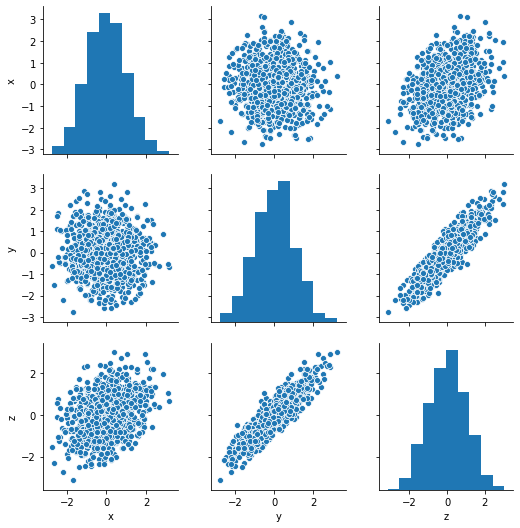

In [10]:
(
    md_mv
    >> gr.ev_monte_carlo(n=1e3, df_det="nom", skip=True)
    >> gr.pt_auto()
)

Note that in the $d=3$ dimensional case, we have

- three means $\mu_1, \mu_2, \mu_3$
- three standard deviations $\sigma_1, \sigma_2, \sigma_3$
- three correlations $\rho_{1,2}, \rho_{1,3}, \rho_{2,3}$


In the $d=4$ dimensional case, we have

- four means $\mu_1, \mu_2, \mu_3, \mu_4$
- four standard deviations $\sigma_1, \sigma_2, \sigma_3, \sigma_4$
- six correlations $\rho_{1,2}, \rho_{1,3}, \rho_{1,4}, \rho_{2,3}, \rho_{2,4}, \rho_{3,4}$


### Mean and Variance of the Gaussian

We package together the parameters above into a vector mean $\mu$ and variance-covariance matrix $\Sigma$. In the three-dimensional case we have:

$$\mu^{\top} = \left(\mu_1, \mu_2, \mu_3\right)$$
$$\Sigma = \left(\begin{array}{ccc} \sigma_1^2 & \sigma_1\sigma_2 \rho_{1,2} & \sigma_1\sigma_3 \rho_{1,3} \\ \sigma_1\sigma_2 \rho_{2,1} & \sigma_2^2 & \sigma_2\sigma_3 \rho_{2,3} \\ \sigma_1\sigma_3 \rho_{3,1} & \sigma_2\sigma_3 \rho_{3,2} & \sigma_3^2 \end{array}\right)$$

It's often more convenient to think in terms of the mean $\mu$, standard deviations $\sigma_1, \dots, \sigma_d$, and correlation matrix $R$. We can relate the matrix of standard deviations $D = \text{Diag}[\sigma_1, \dots, \sigma_d]$, correlation matrix $R$, and covariance via

$$\Sigma = D R D$$

In the 3d case, these are

$$R = \left(\begin{array}{ccc} 1 & \rho_{1,2} & \rho_{1,3} \\ \rho_{2,1} & 1 & \rho_{2,3} \\ \rho_{3,1} & \rho_{3,2} & 1 \end{array}\right)$$

$$D = \left(\begin{array}{ccc} \sigma_1 & 0 & 0 \\ 0 & \sigma_2 & 0 \\ 0 & 0 & \sigma_3 \end{array}\right)$$



## Examples

Make sure to test:

- Isotonic
- Uncorrelated, different variances
- Correlated, same variances
- Correlated, different variances


eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.
Calling plot_scattermat....


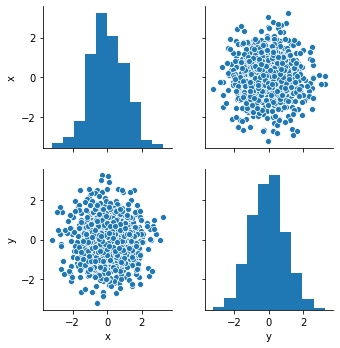

In [11]:
(
    gr.Model("Multivariate Gaussian")
    >> gr.cp_marginals(
        x=dict(dist="norm", loc=0, scale=1),
        y=dict(dist="norm", loc=0, scale=1),
    )
    >> gr.cp_copula_gaussian(
        df_corr=gr.df_make(
            var1=["x"],
            var2=["y"],
            corr=[0.0],
        )
    )
    
    >> gr.ev_monte_carlo(n=1e3, df_det="nom", skip=True)
    >> gr.pt_auto()
)


## Limitations of the Gaussian model

---


### Infinite support


### Symmetry


### Unimodal
